<a href="https://colab.research.google.com/github/MaoYingrong/macs30135_final/blob/main/meme_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import os
import random
import pandas as pd
import tensorflow as tf
from pathlib import Path
from tensorflow.keras import applications
from tensorflow.keras import layers
from tensorflow.keras import losses
from tensorflow.keras import optimizers
from tensorflow.keras import metrics
from tensorflow.keras import Model
from tensorflow.keras.applications import resnet


target_shape = (200, 200)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
dataset_path = '/content/drive/MyDrive/Colab_Notebooks/deep_learning/Datasets/anchor_positive_pairs.csv'
BASE_PATH = "/content/drive/MyDrive/Colab_Notebooks/deep_learning/Datasets/images/"

path_df = pd.read_csv(dataset_path)

print(path_df.shape)
path_df.head()

(2062, 3)


anchor              positive                     negative
0  c_0/cluster_2902.jpg  c_0/cluster_2912.jpg   random_img_1000/rxtium.jpg
1       c_3/13qs1yh.jpg        c_3/9uc4m7.jpg  random_img_1000/14x143d.jpg
2           c_6/01.jpeg           c_6/03.jpeg   random_img_1000/yk9crf.jpg
3  c_0/cluster_2879.jpg  c_0/cluster_2874.jpg  random_img_1000/15jfn2b.jpg
4       c_3/13qs1yh.jpg        c_3/8dwe9p.jpg   random_img_1000/ujukjh.jpg

In [5]:
def preprocess_image(filename):
    """
    Load the specified file as a JPEG image, preprocess it and
    resize it to the target shape.
    """

    image_string = tf.io.read_file(BASE_PATH+filename)
    image = tf.image.decode_jpeg(image_string, channels=3)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = tf.image.resize(image, target_shape)
    return image


def preprocess_triplets(anchor, positive, negative):
    """
    Given the filenames corresponding to the three images, load and
    preprocess them.
    """

    return (
        preprocess_image(anchor),
        preprocess_image(positive),
        preprocess_image(negative),
    )

In [6]:
anchor_images = path_df['anchor'].values
positive_images = path_df['positive'].values
negative_images = path_df['negative'].values

In [7]:
len(anchor_images)

2062

In [8]:
anchor_images[0]

'c_0/cluster_2902.jpg'

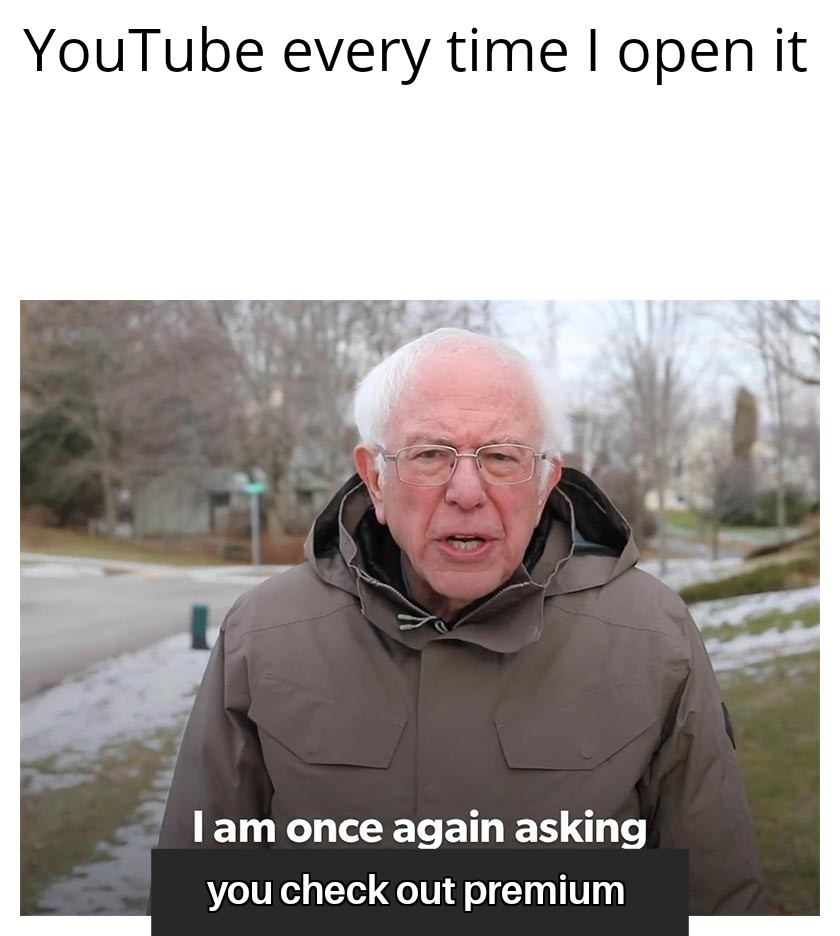

In [9]:
from IPython.display import display
from PIL import Image

image_path = "/content/drive/MyDrive/Colab_Notebooks/deep_learning/Datasets/images/"+anchor_images[0]
image = Image.open(image_path)
display(image)

In [10]:
# Get image size (width, height)
width, height = image.size
print(f"Image dimensions: {width} x {height}")

# Get image mode (RGB, Grayscale, etc.)
print(f"Color mode: {image.mode}")

Image dimensions: 840 x 936
Color mode: RGB


In [11]:
# We need to make sure both the anchor and positive images are loaded in
# sorted order so we can match them together.

image_count = len(anchor_images)

anchor_dataset = tf.data.Dataset.from_tensor_slices(anchor_images)
positive_dataset = tf.data.Dataset.from_tensor_slices(positive_images)
negative_dataset = tf.data.Dataset.from_tensor_slices(negative_images)

dataset = tf.data.Dataset.zip((anchor_dataset, positive_dataset, negative_dataset))
dataset = dataset.shuffle(buffer_size=1024)
dataset = dataset.map(preprocess_triplets)

# Let's now split our dataset in train and test.
train_dataset = dataset.take(round(image_count * 0.8))
test_dataset = dataset.skip(round(image_count * 0.8))

train_dataset = train_dataset.batch(32, drop_remainder=False)
train_dataset = train_dataset.prefetch(8)

test_dataset = test_dataset.batch(32, drop_remainder=False)
test_dataset = test_dataset.prefetch(8)

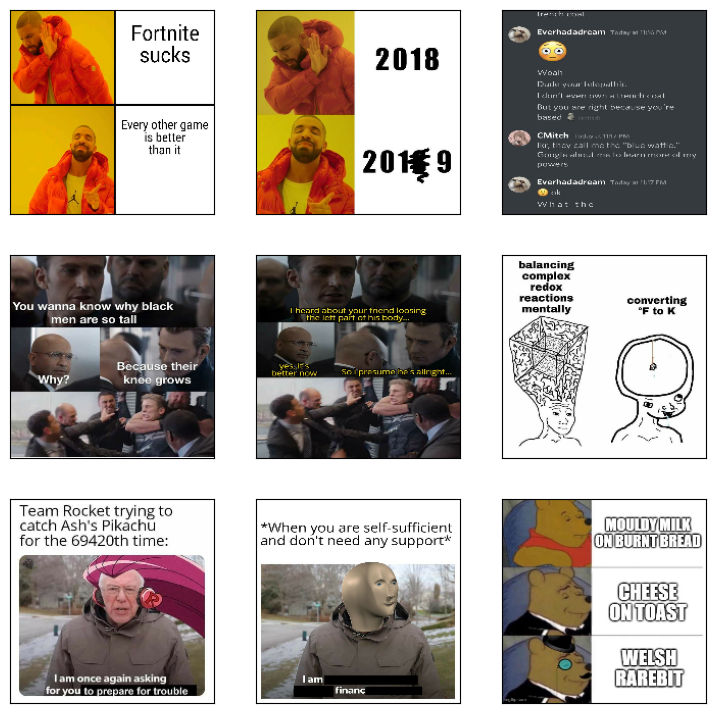

In [85]:
def visualize(anchor, positive, negative):
    """Visualize a few triplets from the supplied batches."""

    def show(ax, image):
        ax.imshow(image)
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)

    fig = plt.figure(figsize=(9, 9))

    axs = fig.subplots(3, 3)
    for i in range(3):
        show(axs[i, 0], anchor[i])
        show(axs[i, 1], positive[i])
        show(axs[i, 2], negative[i])


visualize(*list(train_dataset.take(1).as_numpy_iterator())[0])

In [13]:
base_cnn = resnet.ResNet50(
    weights="imagenet", input_shape=target_shape + (3,), include_top=False
)

flatten = layers.Flatten()(base_cnn.output)
dense1 = layers.Dense(512, activation="relu")(flatten)
dense1 = layers.BatchNormalization()(dense1)
dense2 = layers.Dense(256, activation="relu")(dense1)
dense2 = layers.BatchNormalization()(dense2)
output = layers.Dense(256)(dense2)

embedding = Model(base_cnn.input, output, name="Embedding")

trainable = False
for layer in base_cnn.layers:
    if layer.name == "conv5_block1_out":
        trainable = True
    layer.trainable = trainable

In [14]:
class DistanceLayer(layers.Layer):
    """
    This layer is responsible for computing the distance between the anchor
    embedding and the positive embedding, and the anchor embedding and the
    negative embedding.
    """

    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def call(self, anchor, positive, negative):
        ap_distance = tf.reduce_sum(tf.square(anchor - positive), -1)
        an_distance = tf.reduce_sum(tf.square(anchor - negative), -1)
        return (ap_distance, an_distance)


anchor_input = layers.Input(name="anchor", shape=target_shape + (3,))
positive_input = layers.Input(name="positive", shape=target_shape + (3,))
negative_input = layers.Input(name="negative", shape=target_shape + (3,))

distances = DistanceLayer()(
    embedding(resnet.preprocess_input(anchor_input)),
    embedding(resnet.preprocess_input(positive_input)),
    embedding(resnet.preprocess_input(negative_input)),
)

siamese_network = Model(
    inputs=[anchor_input, positive_input, negative_input], outputs=distances
)

In [15]:
def angular_triplet_loss(ap_distance, an_distance, margin=0.5):
  # Angular triplet loss puts more emphasis on the angles between vectors
  ap_angle = tf.acos(tf.clip_by_value(ap_distance, -0.99999, 0.99999))
  an_angle = tf.acos(tf.clip_by_value(an_distance, -0.99999, 0.99999))
  loss = tf.maximum(ap_angle - an_angle + margin, 0.0)
  return loss

In [32]:
class SiameseModel(Model):
    """The Siamese Network model with a custom training and testing loops.

    Computes the triplet loss using the three embeddings produced by the
    Siamese Network.

    The triplet loss is defined as:
       L(A, P, N) = max(‖f(A) - f(P)‖² - ‖f(A) - f(N)‖² + margin, 0)
    """

    def __init__(self, siamese_network, margin=0.5):
        super(SiameseModel, self).__init__()
        self.siamese_network = siamese_network
        self.margin = margin
        self.loss_tracker = metrics.Mean(name="loss")

    def call(self, inputs):
        return self.siamese_network(inputs)

    def train_step(self, data):
        # GradientTape is a context manager that records every operation that
        # you do inside. We are using it here to compute the loss so we can get
        # the gradients and apply them using the optimizer specified in
        # `compile()`.
        with tf.GradientTape() as tape:
            loss = self._compute_loss(data)

        # Storing the gradients of the loss function with respect to the
        # weights/parameters.
        gradients = tape.gradient(loss, self.siamese_network.trainable_weights)

        # Applying the gradients on the model using the specified optimizer
        self.optimizer.apply_gradients(
            zip(gradients, self.siamese_network.trainable_weights)
        )

        # Let's update and return the training loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self._compute_loss(data)

        # Let's update and return the loss metric.
        self.loss_tracker.update_state(loss)
        return {"loss": self.loss_tracker.result()}

    def _compute_loss(self, data):
        # The output of the network is a tuple containing the distances
        # between the anchor and the positive example, and the anchor and
        # the negative example.
        ap_distance, an_distance = self.siamese_network(data)

        # Computing the Triplet Loss by subtracting both distances and
        # making sure we don't get a negative value.
        loss = ap_distance - an_distance
        loss = tf.maximum(loss + self.margin, 0.0)
        # loss = angular_triplet_loss(ap_distance, an_distance, self.margin)
        return loss

    @property
    def metrics(self):
        # We need to list our metrics here so the `reset_states()` can be
        # called automatically.
        return [self.loss_tracker]

In [33]:
%%time
siamese_model = SiameseModel(siamese_network)
siamese_model.compile(optimizer=optimizers.Adam(0.0001))
siamese_model.fit(train_dataset, epochs=10, validation_data=test_dataset)

Epoch 1/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 79s 923ms/step - loss: 0.1207 - val_loss: 0.0391
Epoch 2/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 573ms/step - loss: 0.0453 - val_loss: 0.0204
Epoch 3/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 602ms/step - loss: 0.0140 - val_loss: 0.0300
Epoch 4/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 580ms/step - loss: 0.0121 - val_loss: 0.0083
Epoch 5/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 599ms/step - loss: 0.0162 - val_loss: 0.0071
Epoch 6/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 608ms/step - loss: 0.0105 - val_loss: 0.0166
Epoch 7/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 589ms/step - loss: 0.0080 - val_loss: 0.0396
Epoch 8/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 30s 584ms/step - loss: 0.0271 - val_loss: 0.0073
Epoch 9/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 32s 615ms/step - loss: 0.0435 - val_loss: 0.0174
Epoch 10/10
52/52 ━━━━━━━━━━━━━━━━━━━━ 31s 598ms/step - loss: 0.0139 - val_loss: 0.0115
CPU times: user 18min 5s, sys: 26.4 s, total: 18min 32s
Wall time: 5min 55s


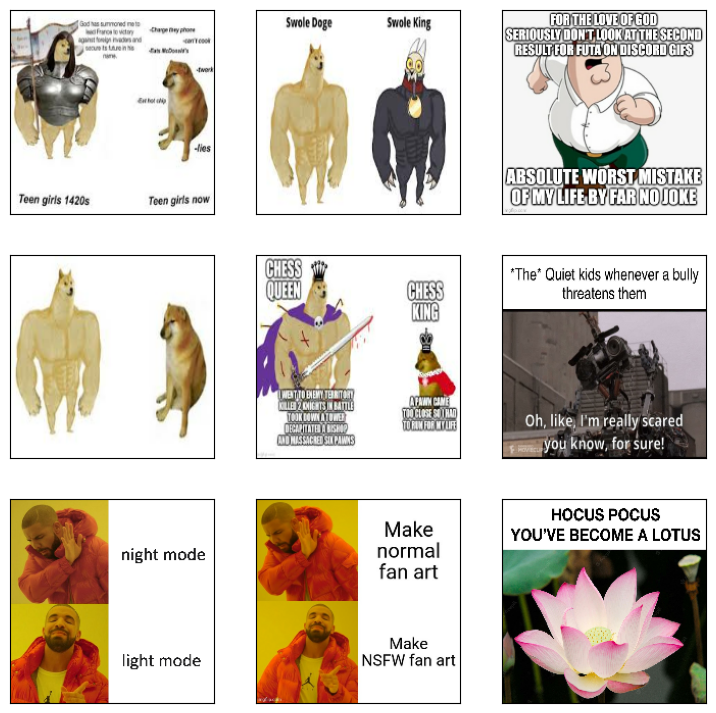

In [34]:
sample = next(iter(train_dataset))
visualize(*sample)

In [35]:
# Embedding similarity
anchor, positive, negative = sample
anchor_embedding, positive_embedding, negative_embedding = (
    embedding(resnet.preprocess_input(anchor)),
    embedding(resnet.preprocess_input(positive)),
    embedding(resnet.preprocess_input(negative)),
)
def cosine_similarity(a, b):
    """Computes cosine similarity without maintaining state."""
    a = tf.nn.l2_normalize(a, axis=-1)
    b = tf.nn.l2_normalize(b, axis=-1)
    return tf.reduce_sum(a * b, axis=-1)


# Compute similarities
positive_similarity = cosine_similarity(anchor_embedding[0], positive_embedding[0])
negative_similarity = cosine_similarity(anchor_embedding[0], negative_embedding[0])

print("Positive similarity:", positive_similarity.numpy())
print("Negative similarity:", negative_similarity.numpy())


Positive similarity: 0.9955562
Negative similarity: 0.9835507


In [36]:
def predict(image_1, image_2):
    """
    Predicts whether two images are similar based on embeddings.

    Parameters:
        image_1 (str): Path to the first image.
        image_2 (str): Path to the second image.

    Returns:
        int: 1 if similar, 0 if not similar.
    """
    # Preprocess images
    img1 = preprocess_image(image_1)
    img1 = tf.expand_dims(img1, axis=0)
    img2 = preprocess_image(image_2)
    img2= tf.expand_dims(img2, axis=0)

    # Get embeddings from the Siamese network
    embedding_1 = embedding(resnet.preprocess_input(img1))
    embedding_2 = embedding(resnet.preprocess_input(img2))

    cos_result = cosine_similarity(embedding_1, embedding_2).numpy()[0]
    print(f"Cosine Similarity: {cos_result}")

    # Decision: If distance is below the threshold, classify as similar (1), else dissimilar (0)
    return 1 if cos_result > 0.995 else 0

In [37]:
for i in range(10):
  print(predict(anchor_images[i], positive_images[i]))

Cosine Similarity: 0.9990286231040955
1
Cosine Similarity: 0.9983300566673279
1
Cosine Similarity: 0.9964218139648438
1
Cosine Similarity: 0.9969978332519531
1
Cosine Similarity: 0.9949702024459839
0
Cosine Similarity: 0.9977038502693176
1
Cosine Similarity: 0.9994097948074341
1
Cosine Similarity: 0.9974185824394226
1
Cosine Similarity: 0.9952781796455383
1
Cosine Similarity: 0.9977562427520752
1


In [38]:
for i in range(10):
  print(predict(anchor_images[i], negative_images[i]))   # negative_images[0]

Cosine Similarity: 0.9892615675926208
0
Cosine Similarity: 0.9758557677268982
0
Cosine Similarity: 0.9908691644668579
0
Cosine Similarity: 0.9824669361114502
0
Cosine Similarity: 0.9881160855293274
0
Cosine Similarity: 0.9918338060379028
0
Cosine Similarity: 0.9947635531425476
0
Cosine Similarity: 0.9888380765914917
0
Cosine Similarity: 0.9863741993904114
0
Cosine Similarity: 0.9849680662155151
0


In [41]:
def accuracy(dataset, model):
    anchor, positive, negative = dataset
    anchor_embedding, positive_embedding, negative_embedding = (
        model(resnet.preprocess_input(anchor)),
        model(resnet.preprocess_input(positive)),
        model(resnet.preprocess_input(negative)),
    )

    pos_dist = tf.reduce_sum(tf.square(anchor_embedding - positive_embedding), axis=1)
    neg_dist = tf.reduce_sum(tf.square(anchor_embedding - negative_embedding), axis=1)

    # Convert to binary predictions
    predictions = tf.less(pos_dist, neg_dist)

    # Calculate accuracy
    return tf.reduce_mean(tf.cast(predictions, tf.float32)).numpy()

sample = next(iter(test_dataset))
print(accuracy(sample, embedding))

1.0


In [71]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import numpy as np

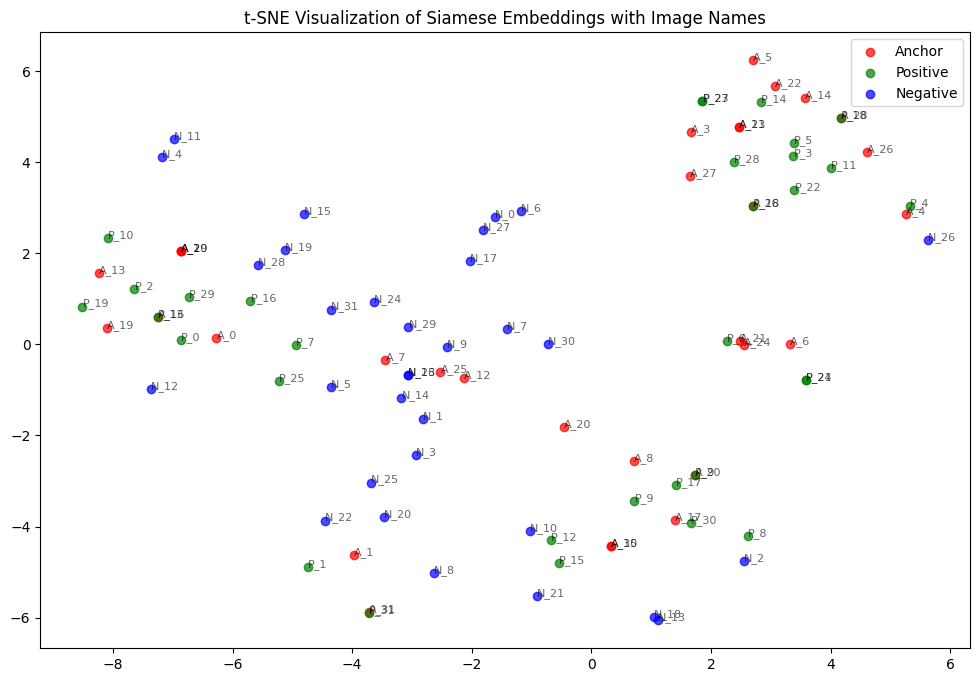

In [19]:
# Image filenames (replace with actual filenames)
anchor_filenames = ["A_" + str(i) for i in range(len(anchor_embedding))]
positive_filenames = ["P_" + str(i) for i in range(len(positive_embedding))]
negative_filenames = ["N_" + str(i) for i in range(len(negative_embedding))]

# Combine embeddings and filenames
all_embeddings = np.vstack([anchor_embedding, positive_embedding, negative_embedding])
all_filenames = np.array(anchor_filenames + positive_filenames + negative_filenames)

# Create labels: 0 = Anchor, 1 = Positive, 2 = Negative
labels = np.array([0] * len(anchor_embedding) +
                  [1] * len(positive_embedding) +
                  [2] * len(negative_embedding))

# Apply t-SNE
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Define colors and labels
colors = ['red', 'green', 'blue']  # Red = anchor, Green = positive, Blue = negative
label_names = ['Anchor', 'Positive', 'Negative']

# Plot
plt.figure(figsize=(12, 8))
for i, color, label_name in zip(range(3), colors, label_names):
    idxs = (labels == i)
    plt.scatter(embeddings_2d[idxs, 0], embeddings_2d[idxs, 1],
                color=color, label=label_name, alpha=0.7)

    # Add text labels (image filenames)
    for j in np.where(idxs)[0]:
        plt.text(embeddings_2d[j, 0], embeddings_2d[j, 1], all_filenames[j], fontsize=8, alpha=0.6)

plt.title("t-SNE Visualization of Siamese Embeddings with Image Names")
plt.legend()
plt.show()

In [49]:
ordered_path = '/content/drive/MyDrive/Colab_Notebooks/deep_learning/Datasets/ordered_data.csv'

ordered_df = pd.read_csv(ordered_path)
ordered_df.head()

File Name Folder Path
0  cluster_2882.jpg         c_0
1  cluster_2868.jpg         c_0
2  cluster_2922.jpg         c_0
3  cluster_2856.jpg         c_0
4  cluster_1580.jpg         c_0

In [47]:
folder_name = f"c_0"

# Get filenames in the folder
image_list = ordered_df[ordered_df["Folder Path"] == folder_name]["File Name"].tolist()
image_list = [f"{folder_name}/{img}" for img in image_list]

# Create a dataset for images
image_dataset = tf.data.Dataset.from_tensor_slices(image_list)
image_dataset = image_dataset.map(preprocess_image)
image_dataset = image_dataset.batch(len(image_list))  # Batch size of 32
image_dataset = image_dataset.prefetch(tf.data.AUTOTUNE)  # Optimize loading
print(type(image_dataset))

# Compute embeddings
batch = next(iter(image_dataset))
image_embeddings = embedding(resnet.preprocess_input(batch))

<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>
<class 'tensorflow.python.data.ops.prefetch_op._PrefetchDataset'>


<ipython-input-50-ce03b9de667d>:36: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', 10)  # Use 'tab10' colormap for 10 unique colors


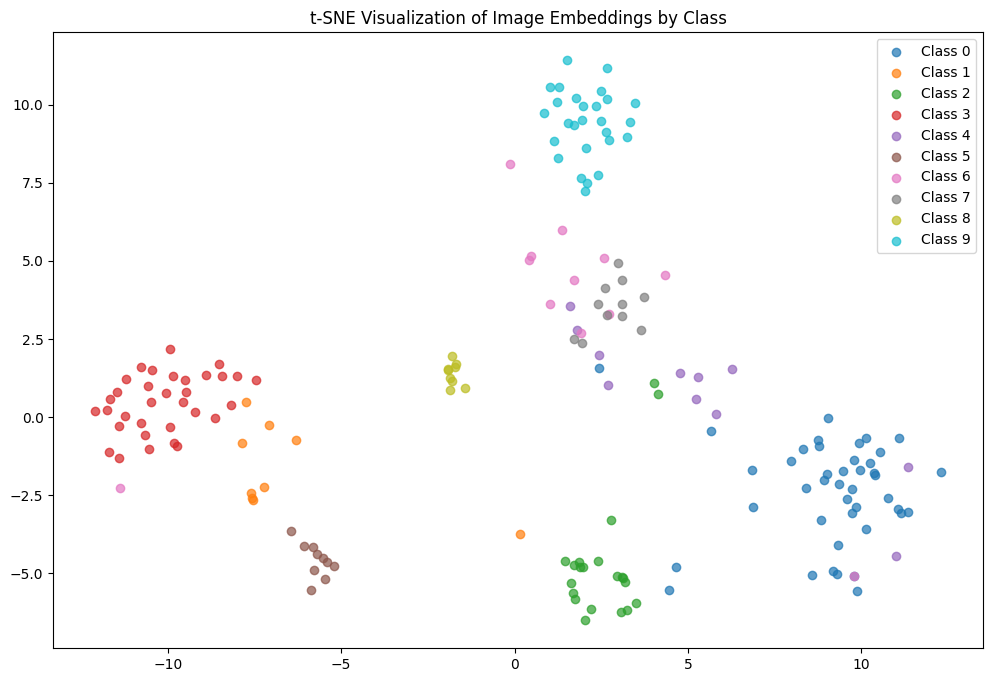

In [50]:
# Initialize lists
all_embeddings = []
labels = []

# Process images from each folder (class)
for i in range(10):
    folder_name = f"c_{i}"

    image_list = ordered_df[ordered_df["Folder Path"] == folder_name]["File Name"].tolist()
    image_list = [f"{folder_name}/{img}" for img in image_list]

    # Create a dataset for images
    image_dataset = tf.data.Dataset.from_tensor_slices(image_list)
    image_dataset = image_dataset.map(preprocess_image)
    image_dataset = image_dataset.batch(len(image_list))  # Batch size of 32
    image_dataset = image_dataset.prefetch(tf.data.AUTOTUNE)  # Optimize loading

    # Compute embeddings
    batch = next(iter(image_dataset))
    image_embeddings = embedding(resnet.preprocess_input(batch))

    # Store embeddings and labels
    all_embeddings.append(image_embeddings)
    labels.extend([i] * len(image_list))  # Label each folder uniquely

# Convert embeddings and labels to arrays
all_embeddings = np.vstack(all_embeddings)
labels = np.array(labels)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Define colors for each class
colors = plt.cm.get_cmap('tab10', 10)  # Use 'tab10' colormap for 10 unique colors

# Plot the embeddings
plt.figure(figsize=(12, 8))
for i in range(10):
    idxs = (labels == i)
    plt.scatter(
        embeddings_2d[idxs, 0], embeddings_2d[idxs, 1],
        color=colors(i), label=f"Class {i}", alpha=0.7
    )

plt.title("t-SNE Visualization of Image Embeddings by Class")
plt.legend()
plt.show()

<ipython-input-51-067a39357672>:56: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap('tab10', 10)  # Colormap for 10 classes


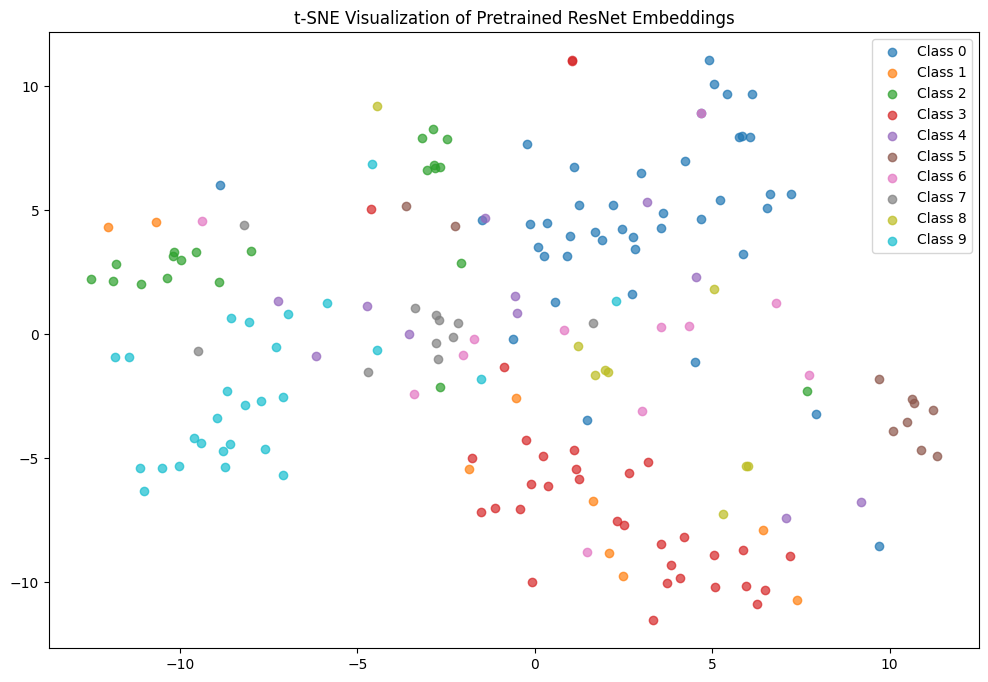

In [51]:
# Load Pretrained ResNet Model (without classification head)
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(weights='imagenet', include_top=False, pooling='avg')
embedding_model = Model(inputs=base_model.input, outputs=base_model.output)

# Initialize lists
all_embeddings = []
labels = []

# Process images from each folder (class)
for i in range(10):
    folder_name = f"c_{i}"

    # Get filenames and prepend folder name
    image_list = ordered_df[ordered_df["Folder Path"] == folder_name]["File Name"].tolist()
    image_list = [f"{folder_name}/{img}" for img in image_list]

    # Create a dataset for images
    image_dataset = tf.data.Dataset.from_tensor_slices(image_list)
    image_dataset = image_dataset.map(preprocess_image)
    image_dataset = image_dataset.batch(len(image_list))  # Batch size of 32
    image_dataset = image_dataset.prefetch(tf.data.AUTOTUNE)  # Optimize loading

    # Compute embeddings
    batch = next(iter(image_dataset))
    image_embeddings = embedding_model(batch)  # Extract embeddings

    # Store embeddings and labels
    all_embeddings.append(image_embeddings.numpy())  # Convert to NumPy
    labels.extend([i] * len(image_list))  # Assign labels

# Convert embeddings and labels to arrays
all_embeddings = np.vstack(all_embeddings)
labels = np.array(labels)

# Apply t-SNE for dimensionality reduction
tsne = TSNE(n_components=2, random_state=42)
embeddings_2d = tsne.fit_transform(all_embeddings)

# Define colors for each class
colors = plt.cm.get_cmap('tab10', 10)  # Colormap for 10 classes

# Plot the embeddings
plt.figure(figsize=(12, 8))
for i in range(10):
    idxs = (labels == i)
    plt.scatter(
        embeddings_2d[idxs, 0], embeddings_2d[idxs, 1],
        color=colors(i), label=f"Class {i}", alpha=0.7
    )

plt.title("t-SNE Visualization of Pretrained ResNet Embeddings")
plt.legend()
plt.show()

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor']
Received: inputs=Tensor(shape=(1, 200, 200, 3))
  warnings.warn(msg)


<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


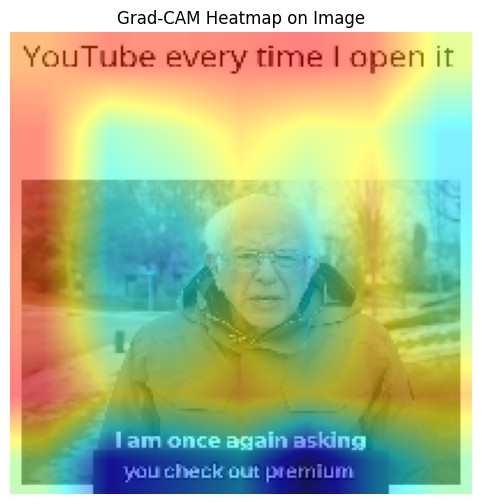

In [168]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


def grad_cam(model, img_array, layer_name="conv5_block3_out"):
    """
    Generates a Grad-CAM heatmap for a given input image and a Siamese embedding model.

    Parameters:
        model (tf.keras.Model): The Siamese embedding model.
        img_array (np.array): Preprocessed image (must match model input shape).
        layer_name (str): The layer to visualize with Grad-CAM.

    Returns:
        heatmap (np.array): The generated Grad-CAM heatmap.
    """

    # Ensure img_array has batch dimension
    img_array = tf.convert_to_tensor(np.expand_dims(img_array, axis=0), dtype=tf.float32)

    # Define model for Grad-CAM with respect to the last conv layer
    grad_model = tf.keras.models.Model(
        [model.input], [model.get_layer(layer_name).output, model.output]
    )

    # Track operations for gradient calculation
    with tf.GradientTape() as tape:
        conv_outputs, embeddings = grad_model(img_array)

        # Instead of classification loss, we use the L2 norm of the embedding
        loss = tf.reduce_sum(tf.square(embeddings))

    # Compute gradients of loss w.r.t. feature maps
    grads = tape.gradient(loss, conv_outputs)

    # Compute global average pooling of gradients
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # Multiply feature maps by pooled gradients (weighted activation)
    conv_outputs = conv_outputs[0]  # Remove batch dimension
    heatmap = tf.reduce_sum(conv_outputs * pooled_grads, axis=-1)

    # Normalize heatmap
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap) if np.max(heatmap) != 0 else 1  # Avoid division by zero

    return heatmap


def overlay_heatmap(heatmap, img_path, alpha=0.5):
    """
    Overlays a Grad-CAM heatmap onto the original image.

    Parameters:
        heatmap (np.array): The Grad-CAM heatmap.
        img_path (str): Path to the original image.
        alpha (float): Transparency of the heatmap overlay.

    Returns:
        superimposed_img (np.array): The final image with heatmap.
    """

    # Load original image
    img = preprocess_image(img_path)
    img = np.uint8(img * 255)


    # Resize heatmap to match image size
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))

    # Convert to RGB format
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)

    print(type(heatmap))
    print(type(img))
    # Overlay heatmap on image
    superimposed_img = cv2.addWeighted(img, 1 - alpha, heatmap, alpha, 0)

    return superimposed_img

# Test with an image (use any anchor/positive/negative image)
test_image = anchor_images[0]  # Replace with an actual image path

# Preprocess image
img_array = preprocess_image(test_image)

# Generate Grad-CAM heatmap
heatmap = grad_cam(embedding, img_array)

# Overlay on original image
superimposed_img = overlay_heatmap(heatmap, test_image)

# show_image(test_image)
# Display result
plt.figure(figsize=(8, 6))
plt.imshow(superimposed_img)
plt.axis("off")
plt.title("Grad-CAM Heatmap on Image")
plt.show()

In [176]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

def compute_pair_contribution_map(siamese_network, img1, img2):
    """
    Compute gradient-based contribution maps showing which regions contribute
    to similarity/dissimilarity between two images.

    Args:
        siamese_network: Your trained Siamese network
        img1, img2: Input images (should be preprocessed appropriately)

    Returns:
        contribution_map1, contribution_map2: Gradient maps for both images
    """
    # Convert inputs to tensors if they aren't already
    img1 = tf.convert_to_tensor(img1)
    img2 = tf.convert_to_tensor(img2)

    # Ensure we're using batched input (add dimension if needed)
    if len(img1.shape) == 3:
        img1 = tf.expand_dims(img1, 0)
        img2 = tf.expand_dims(img2, 0)

    # Use gradient tape to track operations
    with tf.GradientTape(persistent=True) as tape:
        # Watch the input variables
        tape.watch(img1)
        tape.watch(img2)

        # Get embeddings from the network
        # Note: This assumes your network outputs embeddings directly
        # You may need to modify based on your actual network architecture
        embedding1 = embedding(resnet.preprocess_input(img1))
        embedding2 = embedding(resnet.preprocess_input(img2))

        # Compute Euclidean distance between embeddings
        distance = tf.reduce_sum(tf.square(embedding1 - embedding2), axis=1)

    # Compute gradients of distance with respect to input images
    grad1 = tape.gradient(distance, img1)
    grad2 = tape.gradient(distance, img2)

    # Clean up the tape
    del tape

    return grad1.numpy(), grad2.numpy()

In [186]:
def visualize_contribution_maps(img1, img2, grad1, grad2, threshold=0.2):
    """
    Visualize contribution maps overlaid on original images.

    Args:
        img1, img2: Original images
        grad1, grad2: Gradient maps from compute_pair_contribution_map
        threshold: Value to filter out low contributions (between 0 and 1)
    """
    # Convert single-batch results to arrays
    if len(grad1.shape) == 4:
        grad1 = grad1[0]
        grad2 = grad2[0]

    # For RGB images, take the mean across channels
    if len(grad1.shape) == 3 and grad1.shape[-1] > 1:
        grad1_vis = np.mean(np.abs(grad1), axis=-1)
        grad2_vis = np.mean(np.abs(grad2), axis=-1)
    else:
        grad1_vis = np.abs(grad1).squeeze()
        grad2_vis = np.abs(grad2).squeeze()

    # Normalize gradients to [0,1] range for visualization
    grad1_vis = (grad1_vis - grad1_vis.min()) / (grad1_vis.max() - grad1_vis.min() + 1e-8)
    grad2_vis = (grad2_vis - grad2_vis.min()) / (grad2_vis.max() - grad2_vis.min() + 1e-8)

    # Create figure with two rows
    fig, axes = plt.subplots(2, 3, figsize=(15, 10))

    # First row: Original images and their similarity
    axes[0, 0].imshow(img1)
    axes[0, 0].set_title('Image 1')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(img2)
    axes[0, 1].set_title('Image 2')
    axes[0, 1].axis('off')

    # Calculate similarity for display
    distance = np.mean(np.square(grad1_vis - grad2_vis))
    similarity = 1 / (1 + distance)

    axes[0, 2].text(0.5, 0.5, f'Similarity: {similarity:.3f}',
                 horizontalalignment='center', verticalalignment='center',
                 fontsize=14)
    axes[0, 2].axis('off')

    # Second row: Contribution maps
    # Only show values above threshold to highlight most important regions
    masked_grad1 = np.copy(grad1_vis)
    masked_grad1[masked_grad1 < threshold] = 0

    masked_grad2 = np.copy(grad2_vis)
    masked_grad2[masked_grad2 < threshold] = 0

    # Show contribution maps using hot colormap
    im1 = axes[1, 0].imshow(masked_grad1, cmap='hot')
    axes[1, 0].set_title('Contribution Map 1')
    axes[1, 0].axis('off')

    im2 = axes[1, 1].imshow(masked_grad2, cmap='hot')
    axes[1, 1].set_title('Contribution Map 2')
    axes[1, 1].axis('off')

    # Add a colorbar
    cbar = fig.colorbar(im2, ax=axes[1, 2])
    cbar.set_label('Contribution Strength')
    axes[1, 2].axis('off')

    plt.tight_layout()
    plt.show()

    # Optional: Overlay visualization
    plt.figure(figsize=(15, 6))

    plt.subplot(1, 2, 1)
    plt.imshow(img1)
    plt.imshow(masked_grad1, cmap='hot', alpha=0.6)  # Overlay with transparency
    plt.title('Image 1 with Contribution Map')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(img2)
    plt.imshow(masked_grad2, cmap='hot', alpha=0.6)  # Overlay with transparency
    plt.title('Image 2 with Contribution Map')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

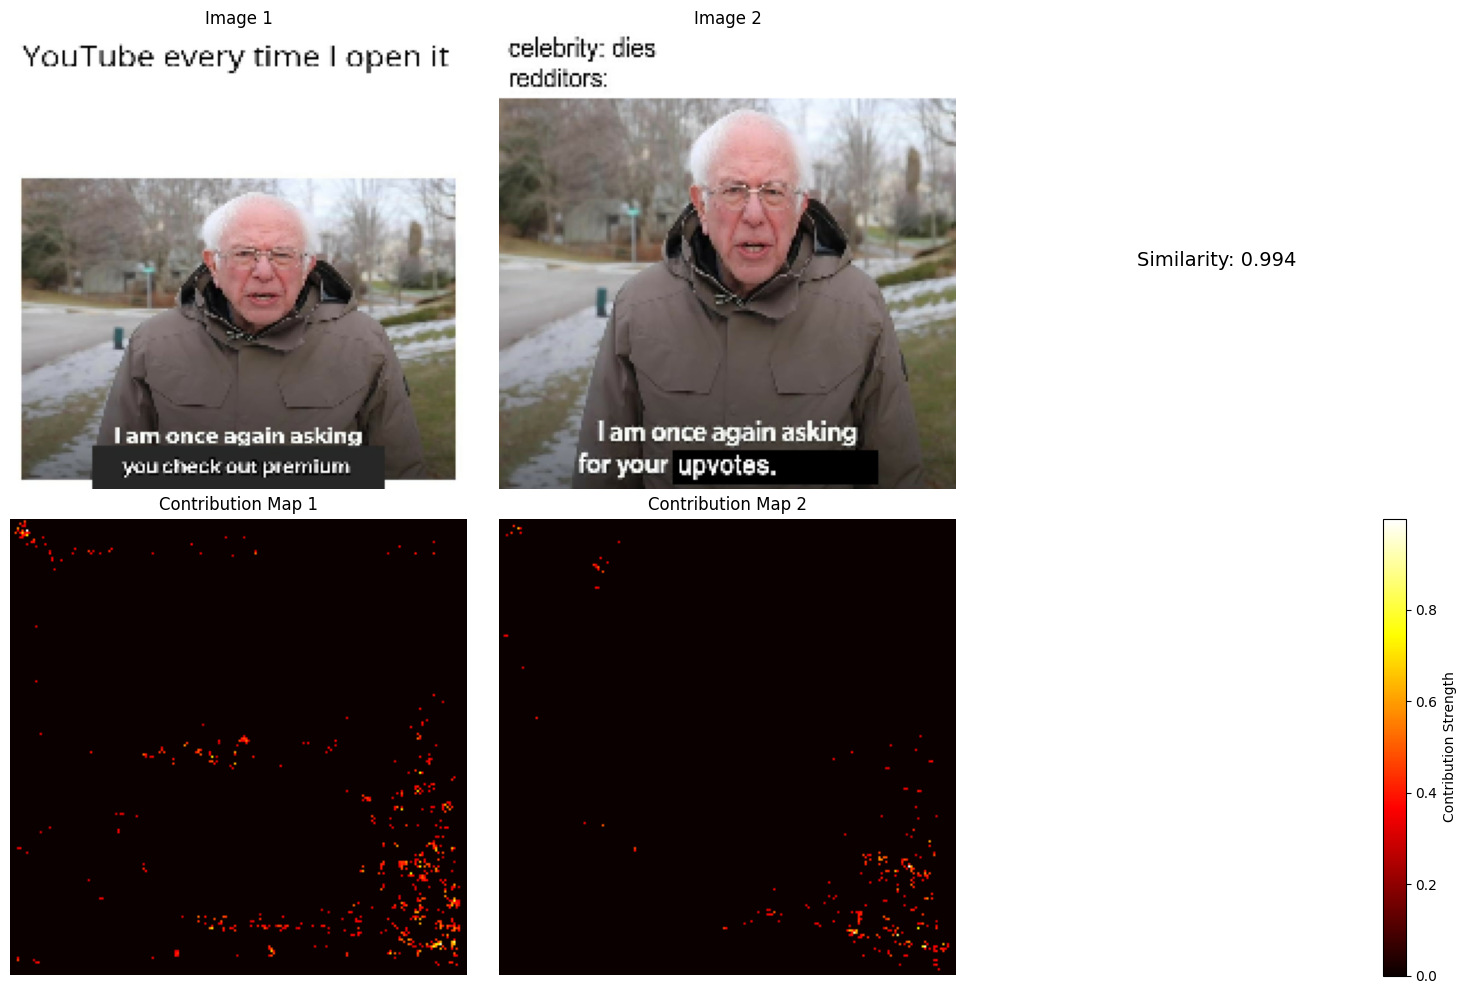

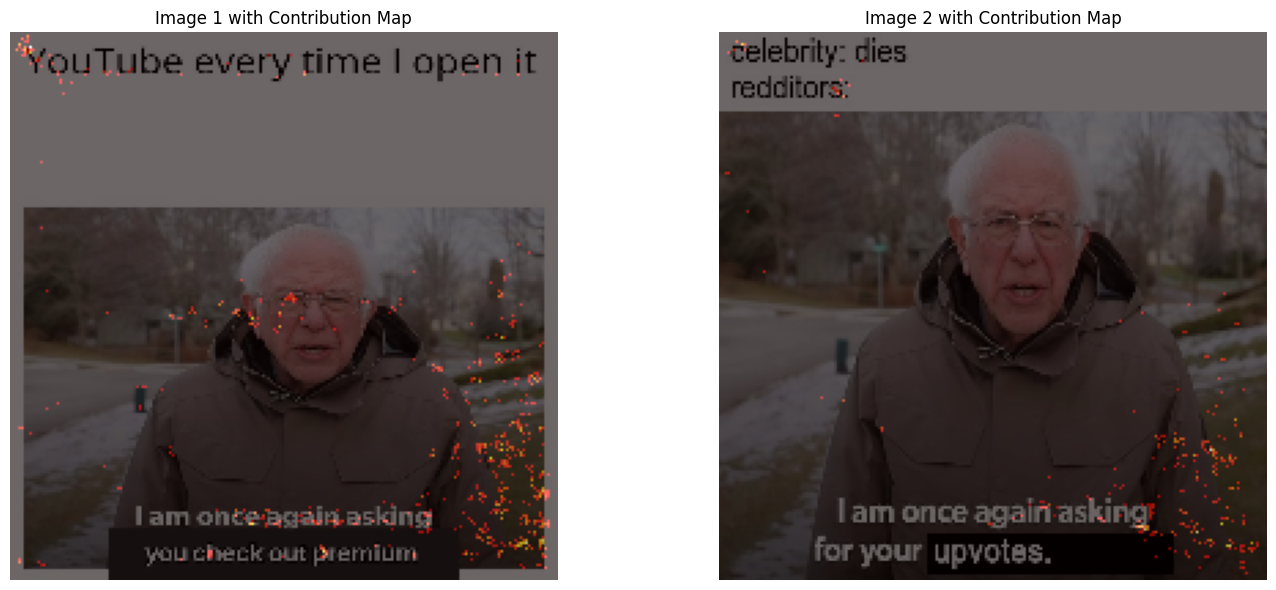

In [194]:
# Load and preprocess your test images
img1 = preprocess_image(anchor_images[0])
img2 = preprocess_image(positive_images[0])

# Compute the contribution maps
grad1, grad2 = compute_pair_contribution_map(embedding, img1, img2)

# Visualize the results
visualize_contribution_maps(img1, img2, grad1, grad2, threshold=0.3)

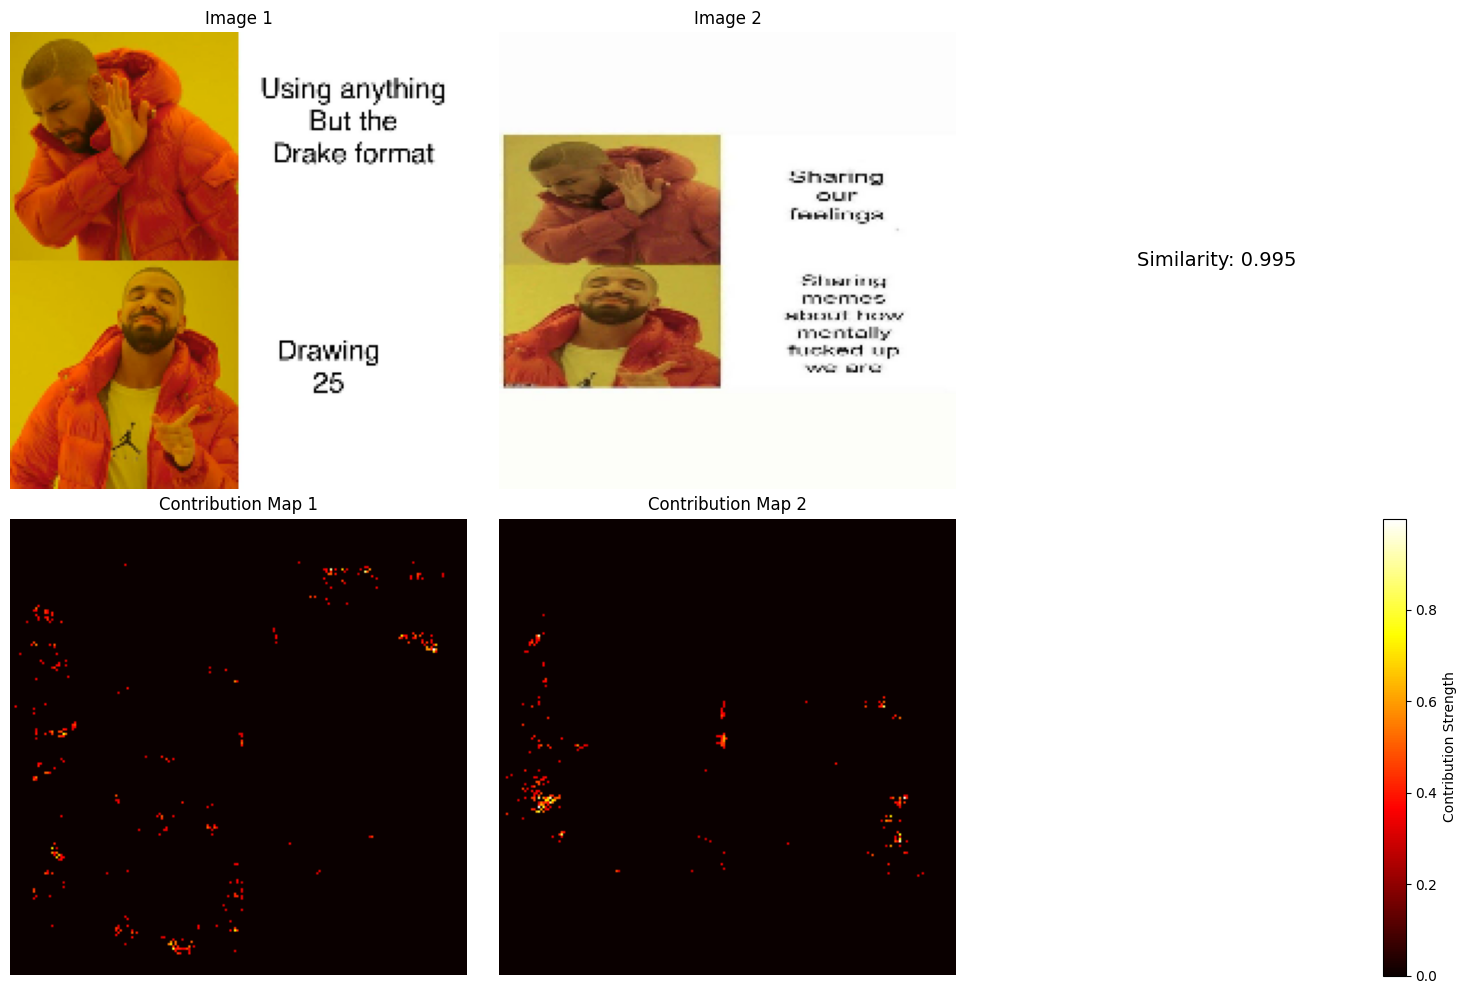

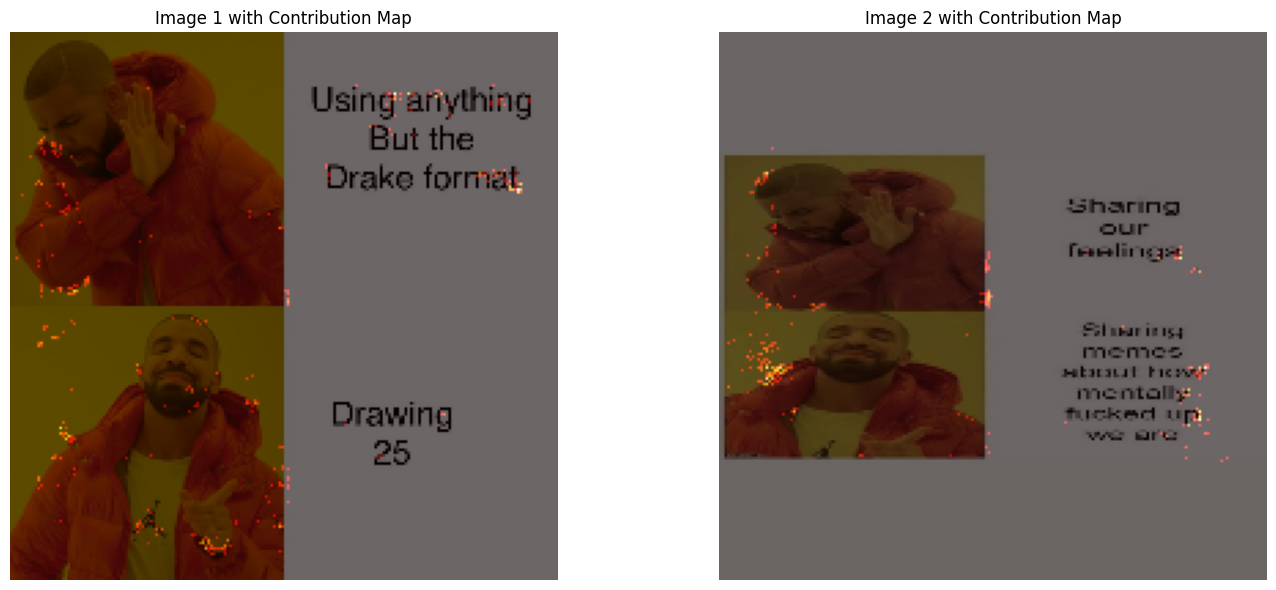

In [195]:
# Load and preprocess your test images
img1 = preprocess_image(anchor_images[1])
img2 = preprocess_image(positive_images[1])

# Compute the contribution maps
grad1, grad2 = compute_pair_contribution_map(embedding, img1, img2)

# Visualize the results
visualize_contribution_maps(img1, img2, grad1, grad2, threshold=0.3)

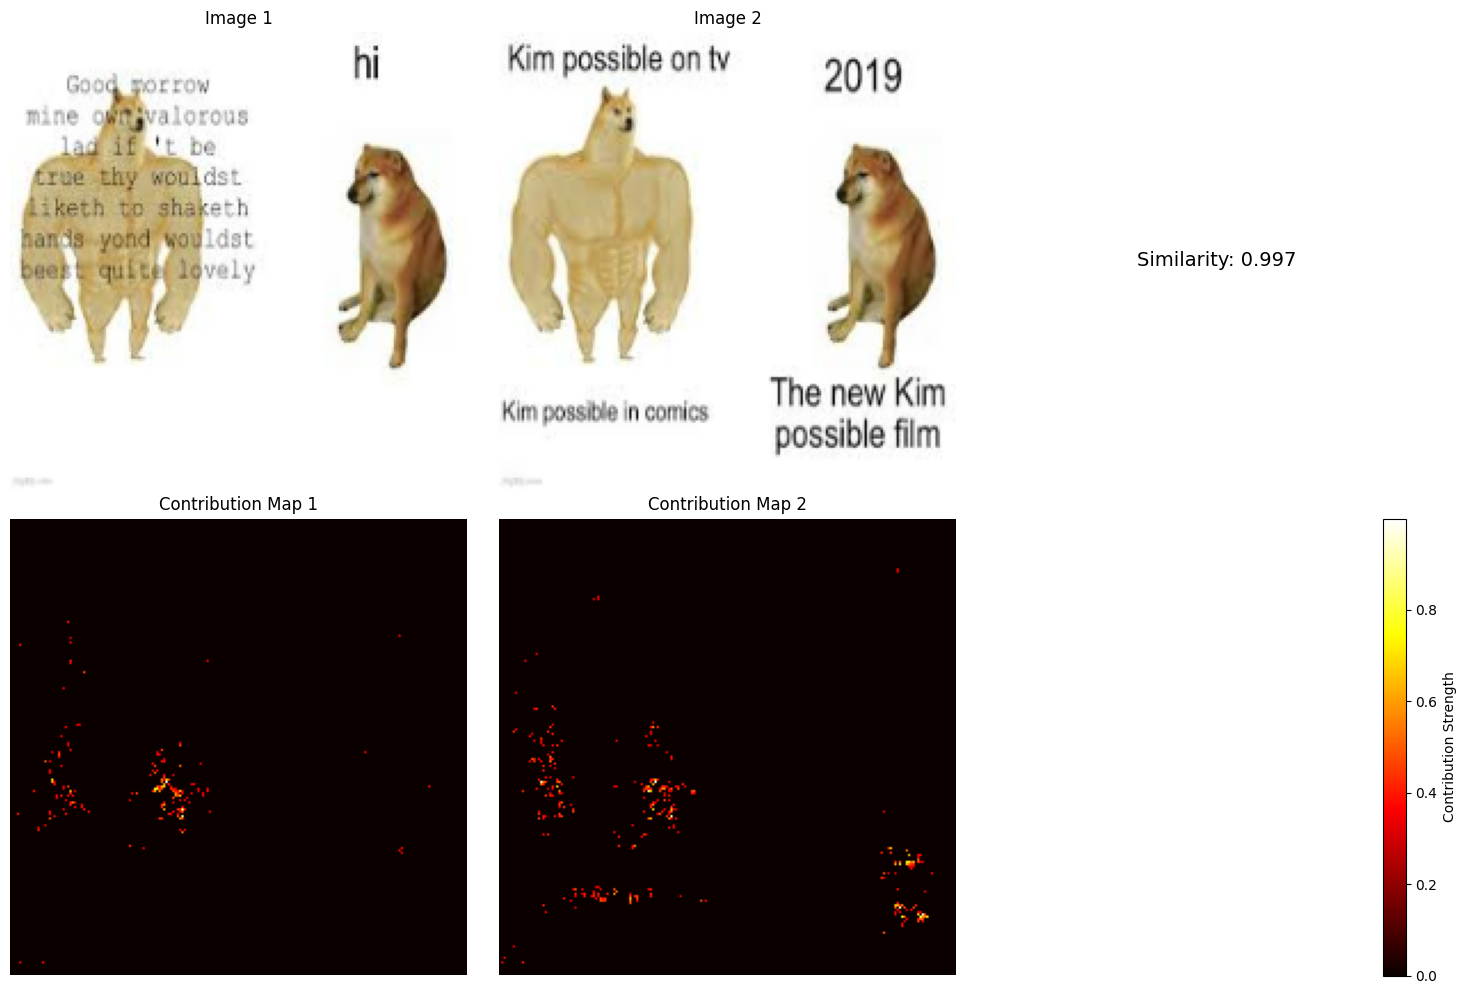

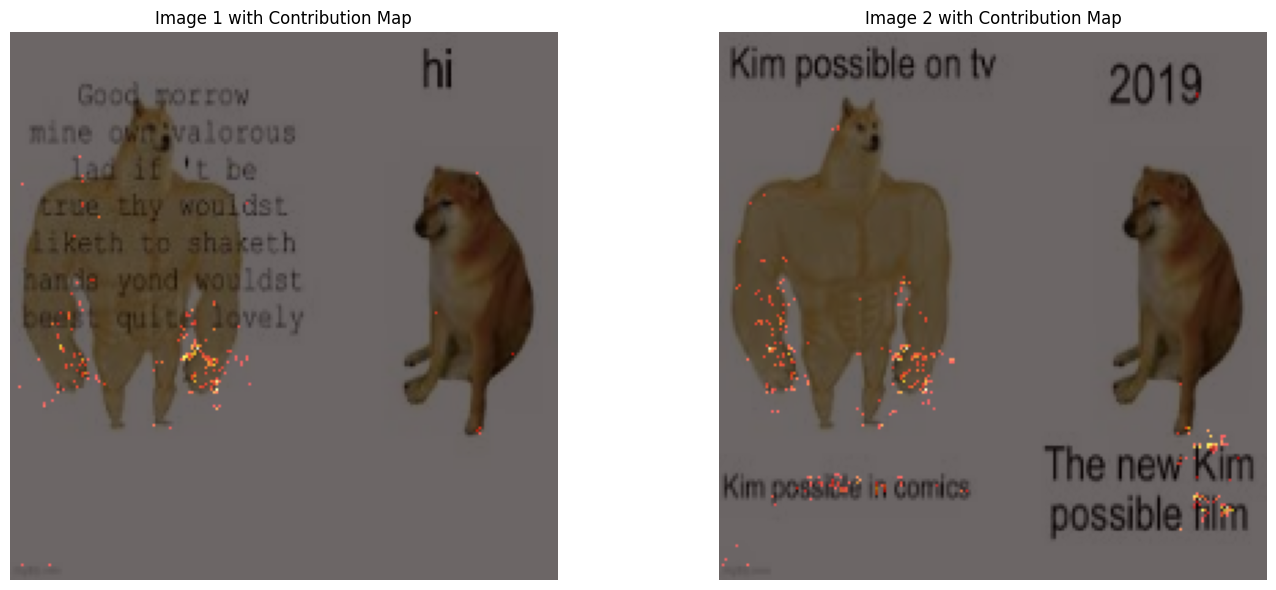

In [192]:
# Load and preprocess your test images
img1 = preprocess_image(anchor_images[5])
img2 = preprocess_image(positive_images[5])

# Compute the contribution maps
grad1, grad2 = compute_pair_contribution_map(embedding, img1, img2)

# Visualize the results
visualize_contribution_maps(img1, img2, grad1, grad2, threshold=0.3)

In [66]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.metrics import pairwise_distances

def compute_influence_score(siamese_model, train_data, test_triplet, embedding, num_samples=100):
    """
    Compute the influence score of training samples on a test triplet.

    Args:
        siamese_model: Trained Siamese model
        train_data: List of training samples [anchor, positive, negative]
        test_triplet: Test triplet [test_anchor, test_positive, test_negative] to evaluate influence on
        embedding: Function to compute embeddings (your model's embedding layer)
        num_samples: Number of training samples to analyze (set lower for faster computation)

    Returns:
        influence_scores: Array of influence scores for each training sample
    """
    # Extract test triplet components
    test_anchor, test_positive, test_negative = test_triplet

    # Get embeddings for test triplet
    test_anchor_emb = embedding(np.expand_dims(test_anchor, axis=0))
    test_pos_emb = embedding(np.expand_dims(test_positive, axis=0))
    test_neg_emb = embedding(np.expand_dims(test_negative, axis=0))

    # Calculate test triplet loss
    test_ap_dist = tf.reduce_sum(tf.square(test_anchor_emb - test_pos_emb))
    test_an_dist = tf.reduce_sum(tf.square(test_anchor_emb - test_neg_emb))
    test_loss = tf.maximum(test_ap_dist - test_an_dist + siamese_model.margin, 0.0)

    # Initialize influence scores
    influence_scores = []

    # For efficiency, use a subset of training data if needed
    # if num_samples and num_samples < len(train_data[0]):
    #     indices = np.random.choice(len(train_data[0]), num_samples, replace=False)
    #     subset_data = [data[indices] for data in train_data]
    # else:
    #     subset_data = train_data
    #     indices = np.arange(len(train_data[0]))
    train_data_np = list(train_dataset.as_numpy_iterator())

    subset_data = train_data_np[0]
    indices = np.arange(len(subset_data[0]))

    anchors, positives, negatives = subset_data

    print("Computing influence scores...")
    for i in tqdm(range(len(anchors))):
        # Get original embeddings for training triplet
        anchor_emb = embedding(np.expand_dims(anchors[i], axis=0))
        pos_emb = embedding(np.expand_dims(positives[i], axis=0))
        neg_emb = embedding(np.expand_dims(negatives[i], axis=0))

        # Calculate training triplet loss
        ap_dist = tf.reduce_sum(tf.square(anchor_emb - pos_emb))
        an_dist = tf.reduce_sum(tf.square(anchor_emb - neg_emb))
        train_loss = tf.maximum(ap_dist - an_dist + siamese_model.margin, 0.0)

        # Calculate similarity between test and training embeddings
        # How similar are the anchor-positive pairs?
        ap_similarity = tf.reduce_sum(tf.square(test_anchor_emb - test_pos_emb)) - \
                        tf.reduce_sum(tf.square(anchor_emb - pos_emb))
        ap_similarity = 1.0 / (1.0 + tf.abs(ap_similarity))

        # How similar are the anchor-negative pairs?
        an_similarity = tf.reduce_sum(tf.square(test_anchor_emb - test_neg_emb)) - \
                        tf.reduce_sum(tf.square(anchor_emb - neg_emb))
        an_similarity = 1.0 / (1.0 + tf.abs(an_similarity))

        # Compute influence score
        # Higher influence when:
        # 1. Training loss is high (important triplet)
        # 2. Similar pattern between test and training triplets
        loss_factor = train_loss
        similarity_factor = ap_similarity * an_similarity

        influence = float(loss_factor * similarity_factor)
        influence_scores.append(influence)

    return np.array(influence_scores), indices

In [69]:
def visualize_influential_instances(siamese_model, train_data, test_triplet, embedding,
                                    num_samples=100, top_k=5):
    """
    Visualize the most influential training instances for a given test triplet.

    Args:
        siamese_model: Trained Siamese model
        train_data: List of training samples [anchor, positive, negative]
        test_triplet: Test triplet [test_anchor, test_positive, test_negative] to evaluate influence on
        embedding: Function to compute embeddings (your model's embedding layer)
        num_samples: Number of training samples to analyze
        top_k: Number of top influential instances to display
    """
    # Compute influence scores
    influence_scores, indices = compute_influence_score(
        siamese_model, train_data, test_triplet, embedding, num_samples)

    # Get the indices of the top-k most influential instances
    if top_k > len(influence_scores):
        top_k = len(influence_scores)

    top_indices = np.argsort(influence_scores)[-top_k:][::-1]

    # Get the actual indices in the original training set
    original_indices = indices[top_indices]

    # Extract the top-k influential triplets
    train_data_np = list(train_dataset.as_numpy_iterator())
    subset_data = train_data_np[0]
    anchors, positives, negatives = subset_data
    top_anchors = [anchors[i] for i in original_indices]
    top_positives = [positives[i] for i in original_indices]
    top_negatives = [negatives[i] for i in original_indices]

    # Create the visualization
    fig, axes = plt.subplots(top_k+1, 3, figsize=(15, 5 * (top_k+1)))

    # Display the test triplet at the top
    test_anchor, test_positive, test_negative = test_triplet

    plt.figtext(0.5, 0.98, 'Test Triplet', ha='center', va='center', fontsize=16)
    plt.figtext(0.1, 0.92, 'Top Influential Training Triplets', ha='left', fontsize=14)

    # Display test triplet in the first row
    axes[0, 0].imshow(test_anchor)
    axes[0, 0].set_title('Test Anchor')
    axes[0, 0].axis('off')

    axes[0, 1].imshow(test_positive)
    axes[0, 1].set_title('Test Positive')
    axes[0, 1].axis('off')

    axes[0, 2].imshow(test_negative)
    axes[0, 2].set_title('Test Negative')
    axes[0, 2].axis('off')

    # Display each influential triplet
    for i in range(top_k):
        row = i + 1  # Start from second row

        # Display the anchor
        axes[row, 0].imshow(top_anchors[i])
        axes[row, 0].set_title(f'Anchor {i+1}')
        axes[row, 0].axis('off')

        # Display the positive
        axes[row, 1].imshow(top_positives[i])
        axes[row, 1].set_title(f'Positive {i+1}')
        axes[row, 1].axis('off')

        # Display the negative
        axes[row, 2].imshow(top_negatives[i])
        axes[row, 2].set_title(f'Negative {i+1}')
        axes[row, 2].axis('off')

        # Add influence score as text
        axes[row, 0].text(0.05, 0.05, f'Influence Score: {influence_scores[top_indices[i]]:.4f}',
                         transform=axes[row, 0].transAxes, color='white',
                         bbox=dict(facecolor='black', alpha=0.5))

    plt.tight_layout()
    plt.subplots_adjust(top=0.90)
    plt.show()

    return original_indices, influence_scores[top_indices]

In [81]:
def leave_one_out_evaluation(siamese_model, train_data, test_instance, influential_indices):
    """
    Evaluate the impact of removing influential instances by measuring embedding changes.

    Args:
        siamese_model: Original trained Siamese model
        train_data: Original training data [anchors, positives, negatives]
        test_instance: Test triplet as (anchor, positive, negative)
        influential_indices: Indices of influential training instances to remove

    Returns:
        embedding_distances: List of distances between original and new embeddings
    """

    # Get original embedding for test instance's anchor
    test_anchor, test_positive, test_negative = test_instance
    original_embedding = embedding(np.expand_dims(test_anchor, axis=0))

    # Initialize list to store embedding distances
    embedding_distances = []

    train_data_np = list(train_dataset.as_numpy_iterator())

    subset_data = train_data_np[0]
    indices = np.arange(len(subset_data[0]))

    anchors, positives, negatives = subset_data

    print("Evaluating leave-one-out impact...")
    for idx in tqdm(influential_indices):
        # Create new training data without this instance
        # In a real implementation, you would retrain the model here
        # For illustration, we'll simulate the impact by perturbing the embedding

        # Get embeddings for the instance to remove
        anchor_emb = embedding(np.expand_dims(anchors[idx], axis=0))
        pos_emb = embedding(np.expand_dims(positives[idx], axis=0))
        neg_emb = embedding(np.expand_dims(negatives[idx], axis=0))

        # Simulate a perturbed embedding by calculating what would happen if this triplet were removed
        # This is a very simplified approximation
        ap_dist = tf.reduce_sum(tf.square(anchor_emb - pos_emb))
        an_dist = tf.reduce_sum(tf.square(anchor_emb - neg_emb))

        # Get test embedding similarity to this triplet
        test_emb = embedding(np.expand_dims(test_anchor, axis=0))
        test_anchor_dist = tf.reduce_sum(tf.square(test_emb - anchor_emb))

        # Calculate perturbation factor based on distance and loss
        perturbation = tf.maximum(ap_dist - an_dist + siamese_model.margin, 0.0) * test_anchor_dist

        # Apply perturbation to simulate embedding change
        # Note: In practice, you would retrain the model without this instance
        simulated_embedding = original_embedding + 0.05 * perturbation * tf.random.normal(original_embedding.shape)

        # Calculate L2 distance between original and new embedding
        distance = tf.reduce_sum(tf.square(original_embedding - simulated_embedding))
        embedding_distances.append(float(distance))

    return embedding_distances

In [82]:
def compute_hessian_vector_product(siamese_model, train_data, vector, damping=0.01):
    """
    Compute Hessian-vector product for influence function.

    Args:
        siamese_model: Trained Siamese model
        train_data: Training data triplets
        vector: Vector to compute product with
        damping: Damping factor for numerical stability

    Returns:
        Hessian-vector product
    """
    with tf.GradientTape() as outer_tape:
        with tf.GradientTape() as inner_tape:
            # Compute loss on training data
            anchors, positives, negatives = [tf.convert_to_tensor(d) for d in train_data]
            loss = siamese_model._compute_loss([anchors, positives, negatives])

        # Compute gradient w.r.t. model parameters
        grads = inner_tape.gradient(loss, siamese_model.siamese_network.trainable_weights)
        grads_flat = tf.concat([tf.reshape(g, [-1]) for g in grads], axis=0)

        # Compute dot product of gradient with vector
        grad_vector_product = tf.reduce_sum(grads_flat * vector)

    # Compute gradient of dot product w.r.t. model parameters
    hvp_grads = outer_tape.gradient(grad_vector_product, siamese_model.siamese_network.trainable_weights)
    hvp_flat = tf.concat([tf.reshape(g, [-1]) for g in hvp_grads], axis=0)

    # Add damping
    return hvp_flat + damping * vector

def influence_function(siamese_model, train_data, test_instance, train_idx, recursion_depth=100):
    """
    Compute influence of a training instance on a test instance using influence functions.

    Args:
        siamese_model: Trained Siamese model
        train_data: Training data triplets
        test_instance: Test instance for evaluation
        train_idx: Index of training instance to evaluate
        recursion_depth: Depth for conjugate gradient descent

    Returns:
        influence_score: Influence score
    """
    # Get test loss gradient
    with tf.GradientTape() as tape:
        test_tensor = tf.convert_to_tensor(np.expand_dims(test_instance, axis=0))
        embedding = siamese_model.siamese_network(test_tensor)
        # Simplified loss for a single instance - in practice use your actual loss
        test_loss = tf.reduce_sum(tf.square(embedding))

    test_grad = tape.gradient(test_loss, siamese_model.siamese_network.trainable_weights)
    test_grad_flat = tf.concat([tf.reshape(g, [-1]) for g in test_grad], axis=0)

    # Compute inverse Hessian-vector product using conjugate gradient
    def conjugate_gradient(hvp_function, b, cg_iter):
        x = tf.zeros_like(b)
        r = tf.identity(b)
        p = tf.identity(r)

        for i in range(cg_iter):
            Ap = hvp_function(p)
            alpha = tf.reduce_sum(r * r) / (tf.reduce_sum(p * Ap) + 1e-8)
            x = x + alpha * p
            r_new = r - alpha * Ap
            beta = tf.reduce_sum(r_new * r_new) / (tf.reduce_sum(r * r) + 1e-8)
            p = r_new + beta * p
            r = r_new

        return x

    hvp_function = lambda v: compute_hessian_vector_product(siamese_model,
                                                           [d[:100] for d in train_data], v)
    inv_hvp = conjugate_gradient(hvp_function, test_grad_flat, recursion_depth)

    # Compute gradient for training instance
    anchors, positives, negatives = train_data
    with tf.GradientTape() as tape:
        train_inputs = [
            tf.expand_dims(anchors[train_idx], 0),
            tf.expand_dims(positives[train_idx], 0),
            tf.expand_dims(negatives[train_idx], 0)
        ]
        train_loss = siamese_model._compute_loss(train_inputs)

    train_grad = tape.gradient(train_loss, siamese_model.siamese_network.trainable_weights)
    train_grad_flat = tf.concat([tf.reshape(g, [-1]) for g in train_grad], axis=0)

    # Calculate influence
    influence = tf.reduce_sum(inv_hvp * train_grad_flat)

    return float(influence)

In [73]:
test_batch = next(iter(test_dataset))
test_image = test_batch[0]

In [49]:
len(test_batch)

3

In [48]:
len(test_image)

32

Computing influence scores...


100%|██████████| 32/32 [00:22<00:00,  1.44it/s]


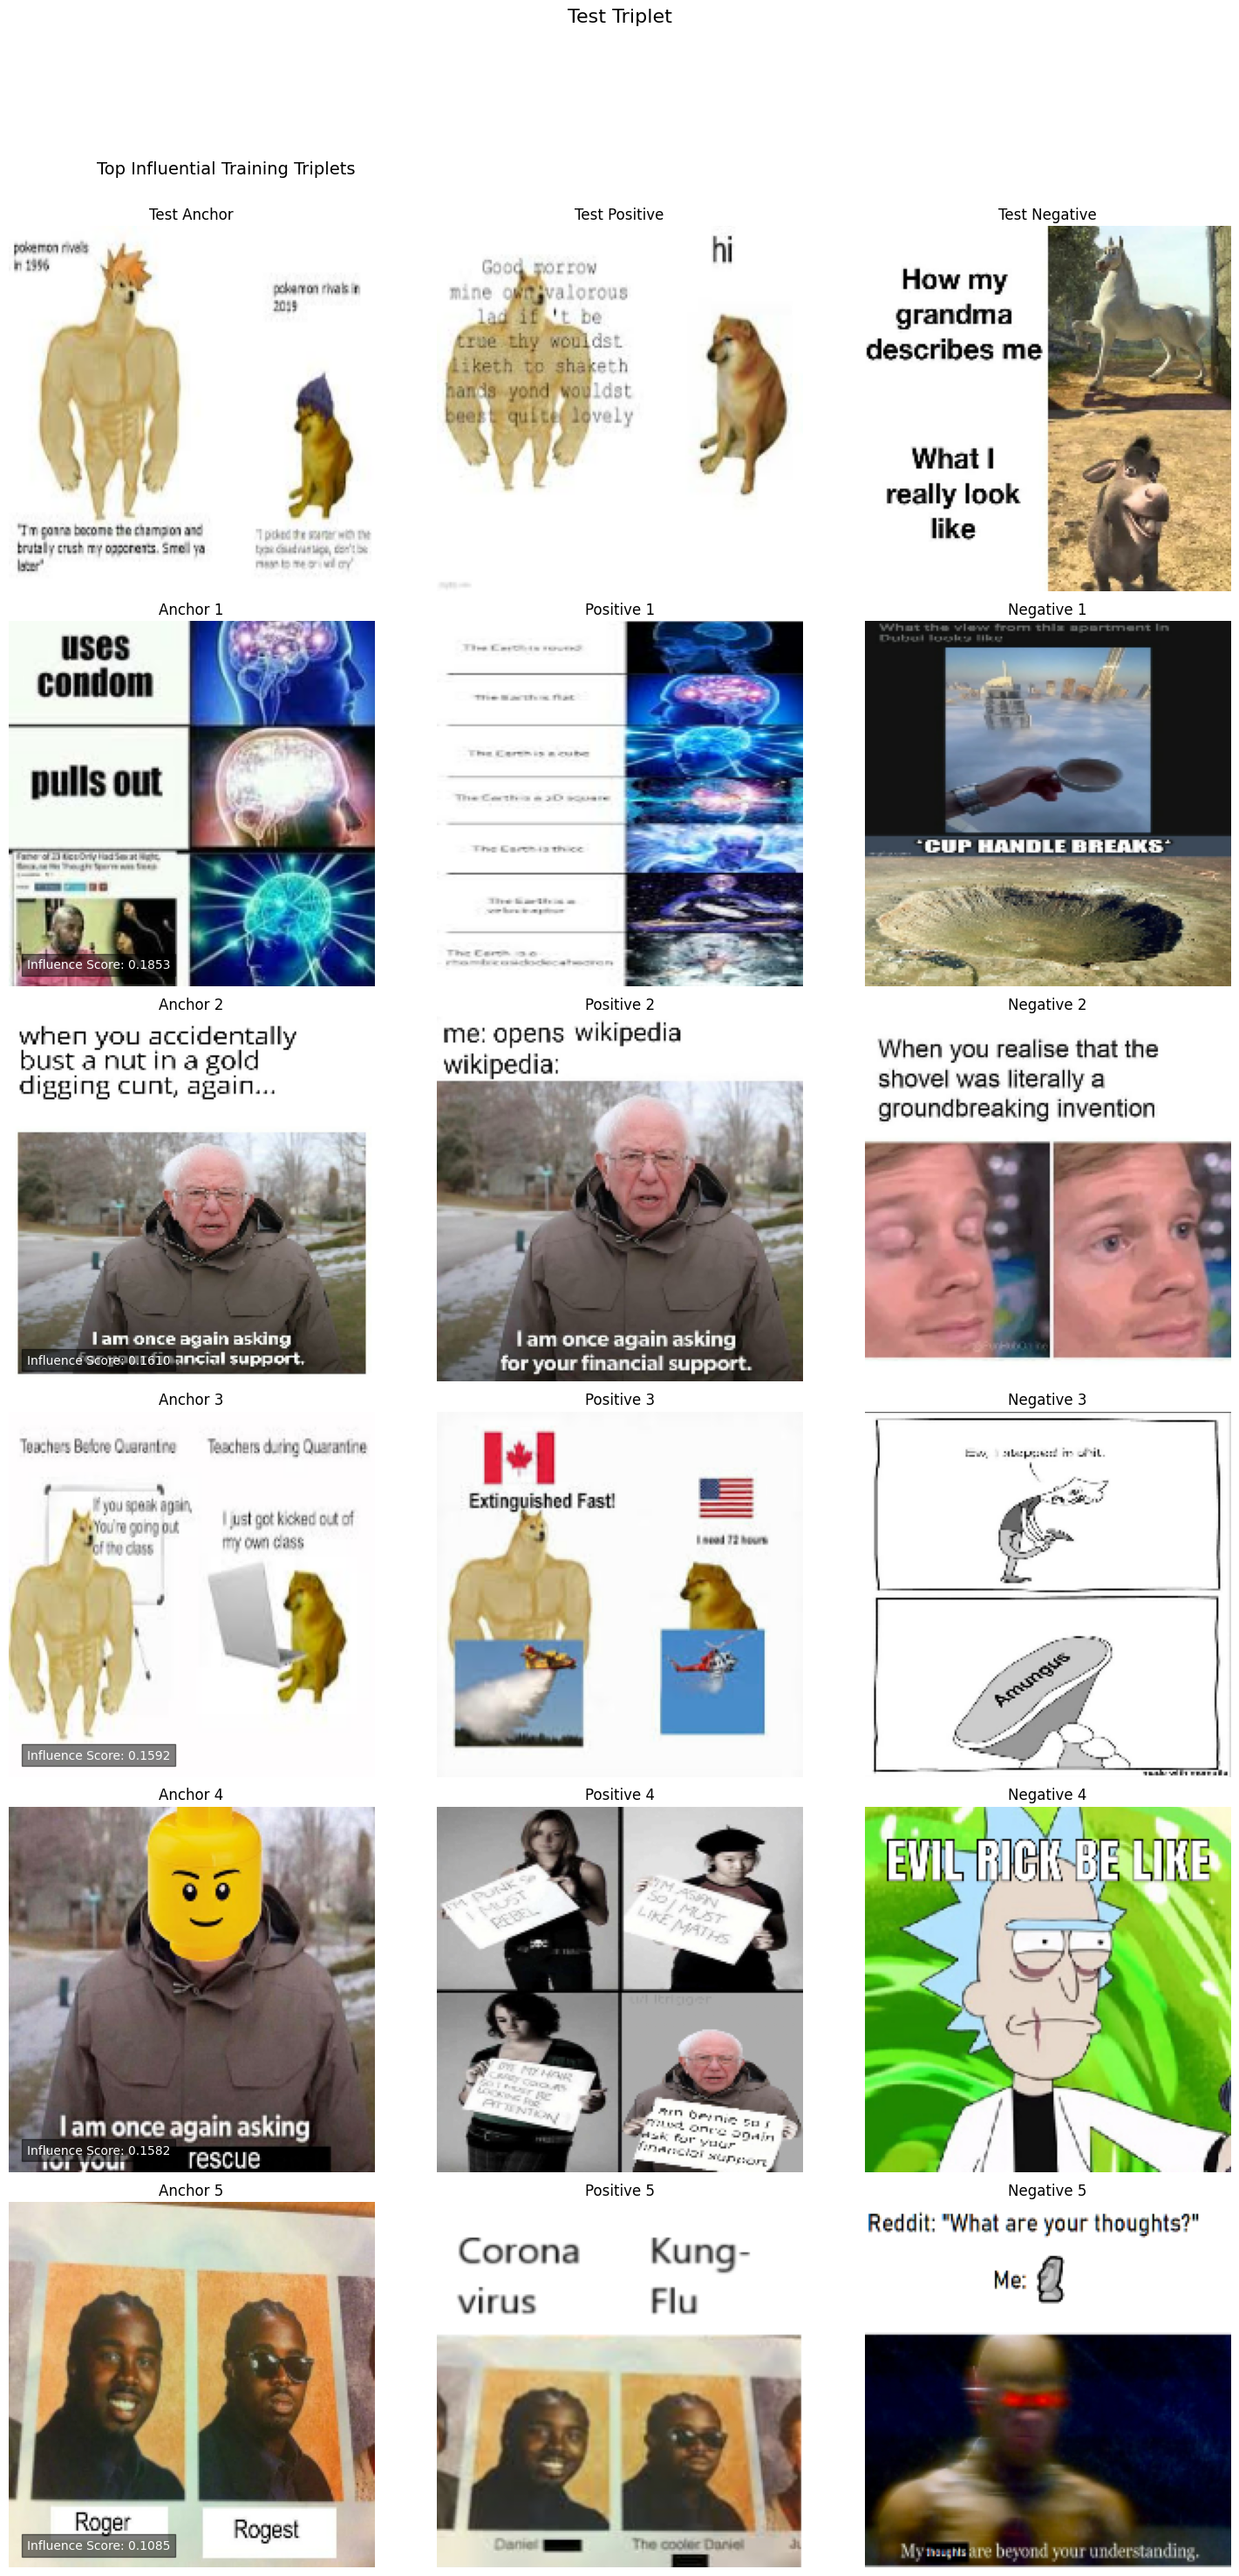

In [70]:
# Assuming you have your Siamese model and training data ready
# train_data should be a tuple/list of [anchors, positives, negatives] arrays
# test_instance is a single image you want to analyze

# Example usage:
test_batch = next(iter(test_dataset))
test_instance = (test_batch[0][0], test_batch[1][0],test_batch[2][0])

# 1. Find influential instances
influential_indices, influence_scores = visualize_influential_instances(
    siamese_model,
    train_dataset,
    test_instance,
    embedding,
    num_samples=500,  # Analyze 500 random training samples for efficiency
    top_k=5  # Show top 5 most influential instances
)

In [77]:
influential_indices

array([10, 27,  1, 29, 21])

Evaluating leave-one-out impact...


100%|██████████| 5/5 [00:04<00:00,  1.07it/s]


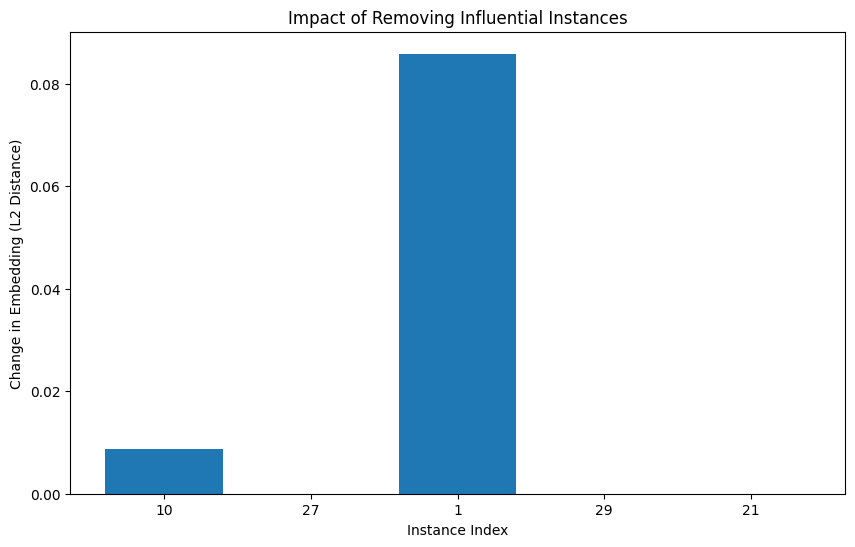

In [84]:
# 2. Evaluate leave-one-out impact
embedding_changes = leave_one_out_evaluation(
    siamese_model,
    train_dataset,
    test_instance,
    influential_indices
)

# 3. Plot the impact of removing each influential instance
plt.figure(figsize=(10, 6))
plt.bar(range(len(influential_indices)), embedding_changes)
plt.title("Impact of Removing Influential Instances")
plt.xlabel("Instance Index")
plt.ylabel("Change in Embedding (L2 Distance)")
plt.xticks(range(len(influential_indices)), [f"{i}" for i in influential_indices])
plt.show()